# Optimise bonded parameters

I use this simple script to optimse the parameters of coarse-grained representation of molecule. The tutorial on how to paramterize molecule is avaible in [cgmartini.nl](http://www.cgmartini.nl/index.php/tutorials-general-introduction-gmx5/parametrzining-new-molecule-gmx5) and here I would like show how to fast optimze point 8 of this tutorial, i.e. optimze bonded parameters.
To do so, we need:
1. All-atomistic simulations
2. Mapping of the structure

To run coarse-grained simulations I use Gromacs with GromacsWrapper, and to analyse the results I use MDAnalysis.

In [10]:
bonded = "/media/piskorz/Research2/Reserach/NDP/NCA/CG/build/bonded.ndx"
mapping = "/media/piskorz/Research2/Reserach/NDP/NCA/CG/build/mapping.ndx"
AA_top = "simulations/AA.pdb"
AA_trj = "simulations/AA.xtc"
CG = "NCA"
CG_top = "simulations/CG.gro"
CG_trj = "simulations/CG.xtc"

In [4]:
import MDAnalysis
import numpy as np
import matplotlib.pyplot as plt

TODOs:
1) Load files nicely
2) Read many molecules
3) Creating analysis
4) Create pdf


Let's put firstly bonded parameters into easier readable format in python:

In [6]:
File = open(bonded)
text = File.read()
File.close()

bonds = []
for line in text[text.find("[ bonds ]")+len("[ bonds ]"): text.find("[ angles ]")].split('\n'):
    if len(line)> 0:
        bonds.append([int(line.split()[0]),int(line.split()[1])])

print "bonds"

print bonds

angles = []
for line in text[text.find("[ angles ]")+len("[ angles ]"): text.find("[ dihedrals ]")].split('\n'):
    if len(line)> 0:
        angles.append([int(line.split()[0]),int(line.split()[1]),int(line.split()[2])])

print "angles"
print angles
dihedrals = []
for line in text[text.find("[ dihedrals ]")+len("[ dihedrals ]"): ].split('\n'):
    if len(line)> 0:
        dihedrals.append([int(line.split()[0]),int(line.split()[1]),
                          int(line.split()[2]),int(line.split()[3])])

print "dihedrals"
print dihedrals

bonds
[[1, 2], [1, 3], [2, 3], [3, 4]]
angles
[[2, 1, 3], [1, 2, 3], [1, 3, 2], [1, 3, 4], [2, 3, 4]]
dihedrals
[[2, 1, 3, 4], [1, 2, 3, 4]]


Now, let's create lists of molecules which will be merged into one bead in coarse-grained representation:

In [7]:
File = open(mapping)
text = File.read()
File.close()
group = {}
last =0
for line in text.split('\n'):
    print line
    if len(line)>0:
        if line[0]=='[':
            group[int(line.split()[1])]=[]
            last = int(line.split()[1])
        else:
            for a in line.split():
                group[last].append(int(a)-1)

[ 1 ]
10 9 7 
[ 2 ]
10 12 14 
[ 3 ]
14 6 7 
[ 4 ]
5 4 2 



### Analysis of bonded parameters of All-atomisc simulation

In every step we calculate center of mass of atoms which form bead in coarse grained representation. Then, we calculate the bonded parameters:

In [1]:
syst= MDAnalysis.Universe(AA_top, AA_trj)
tmax = len(syst.trajectory)
distance= [[0 for b in range(tmax)] for a in range(len(bonds))]
degree= [[0 for b in range(tmax)] for a in range(len(angles))]
dih= [[0 for b in range(tmax)] for a in range(len(dihedrals))]

for ts in syst.trajectory:
    for bond in range(len(bonds)):
        com1 = syst.atoms[group[bonds[bond][0]]].center_of_mass()
        com2 = syst.atoms[group[bonds[bond][1]]].center_of_mass()
        #print com1
        distance[bond][ts.frame]= 0.1*np.sqrt(((MDAnalysis.lib.distances.distance_array(np.array([com1],dtype=np.float32),np.array([com2],dtype=np.float32),syst.trajectory.ts.dimensions[:6])[0])**2)[0]) #calculating distance between middle of molecules -> taking in to account PBC
    for angle in range(len(angles)):
    
        com1 = syst.atoms[group[angles[angle][0]]].center_of_mass()
        com2 = syst.atoms[group[angles[angle][1]]].center_of_mass()
        com3 = syst.atoms[group[angles[angle][2]]].center_of_mass()

        degree[angle][ts.frame]=MDAnalysis.lib.distances.calc_angles(np.array([com1],dtype=np.float32), np.array([com2],dtype=np.float32), np.array([com3],dtype=np.float32))[0]*180.0/np.pi

    for dihedral in range(len(dihedrals)):
    
        com1 = syst.atoms[group[dihedrals[dihedral][0]]].center_of_mass()
        com2 = syst.atoms[group[dihedrals[dihedral][1]]].center_of_mass()
        com3 = syst.atoms[group[dihedrals[dihedral][2]]].center_of_mass()
        com4 = syst.atoms[group[dihedrals[dihedral][3]]].center_of_mass()

        dih[dihedral][ts.frame]=MDAnalysis.lib.distances.calc_dihedrals(np.array([com1],dtype=np.float32), np.array([com2],dtype=np.float32), np.array([com3],dtype=np.float32),np.array([com4],dtype=np.float32))[0]*180.0/np.pi

NameError: name 'MDAnalysis' is not defined

### Analysis of bonded parameters of coarse-grained representation

This analysis is more straight forward we simply calculate bonded parameters:

In [25]:
syst= MDAnalysis.Universe(CG_top, CG_trj)
tmax = len(syst.trajectory)
distance_cg = [[0 for b in range(tmax)] for a in range(len(bonds))]
degree_cg = [[0 for b in range(tmax)] for a in range(len(angles))]
dih_cg = [[0 for b in range(tmax)] for a in range(len(dihedrals))]
mol = syst.select_atoms("resname "+CG)


for ts in syst.trajectory:
    for bond in range(len(bonds)):
        #print bonds[bond]
        #print mol.dih= [[0 for b in range(tmax)] for a in range(len(dihedrals))]atoms[bonds[bond][0]-1], mol.atoms[bonds[bond][1]-1]
        distance_cg[bond][ts.frame]= 0.1*np.sqrt(((MDAnalysis.lib.distances.distance_array(np.array([mol.atoms[bonds[bond][0]-1].pos],dtype=np.float32),
                                                                                        np.array([mol.atoms[bonds[bond][1]-1].pos],dtype=np.float32),syst.trajectory.ts.dimensions[:6])[0])**2)[0]) #calculating distance between middle of molecules -> taking in to account PBC
    for angle in range(len(angles)):
        degree_cg[angle][ts.frame]=MDAnalysis.lib.distances.calc_angles(np.array([mol.atoms[angles[angle][0]-1].pos],dtype=np.float32),
                                                                        np.array([mol.atoms[angles[angle][1]-1].pos],dtype=np.float32),
                                                                        np.array([mol.atoms[angles[angle][2]-1].pos],dtype=np.float32))[0]*180.0/np.pi
    for dihedral in range(len(dihedrals)):
        dih_cg[dihedral][ts.frame]=MDAnalysis.lib.distances.calc_dihedrals(np.array([mol.atoms[dihedrals[dihedral][0]-1].pos],dtype=np.float32),
                                                                           np.array([mol.atoms[dihedrals[dihedral][1]-1].pos],dtype=np.float32),
                                                                           np.array([mol.atoms[dihedrals[dihedral][2]-1].pos],dtype=np.float32),
                                                                           np.array([mol.atoms[dihedrals[dihedral][3]-1].pos],dtype=np.float32))[0]*180.0/np.pi
          



# Bonds

Now, let's compare bonds between coarse-grained and atomistic representation of the molecule:

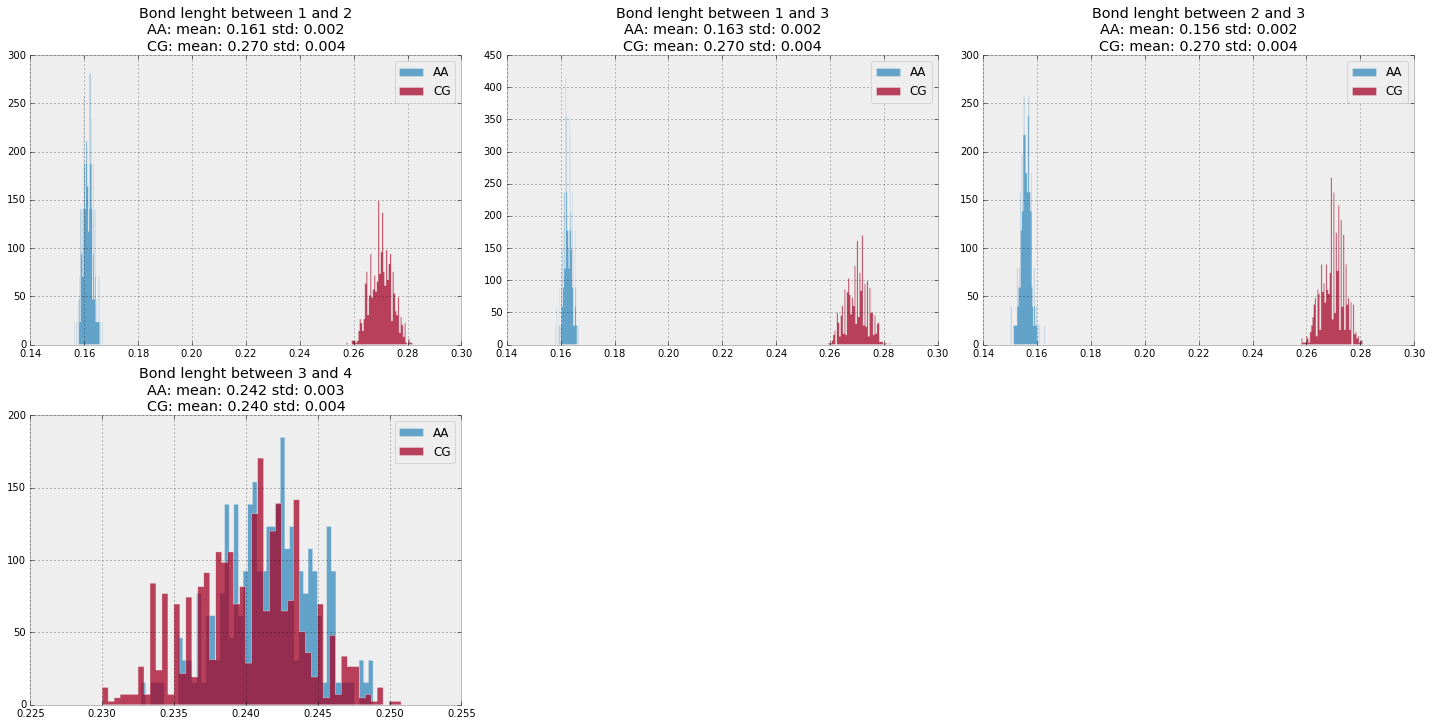

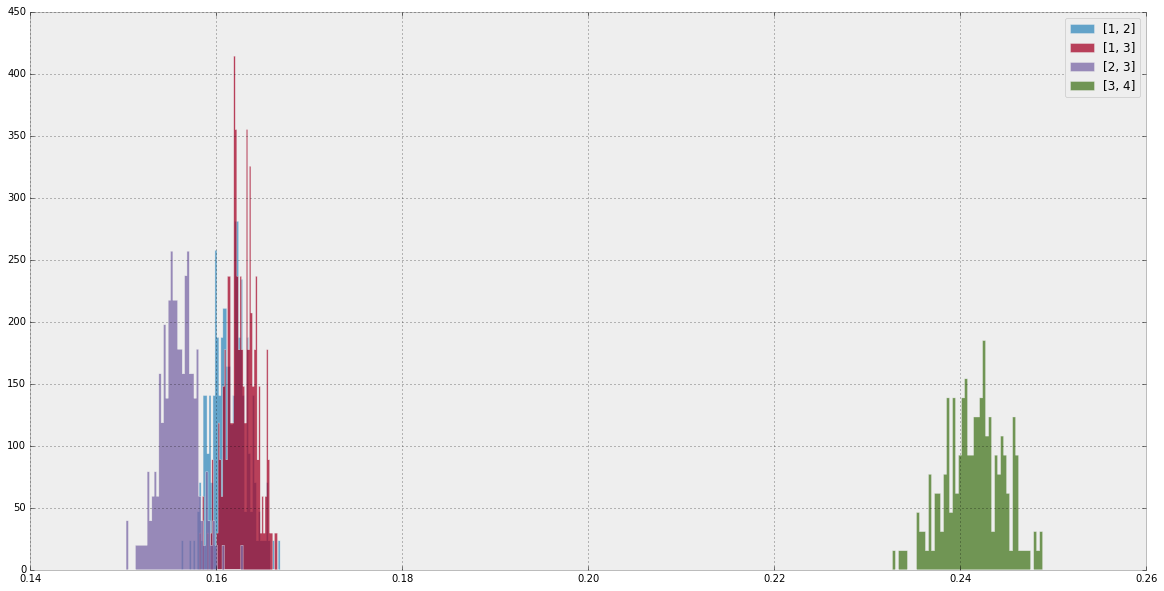

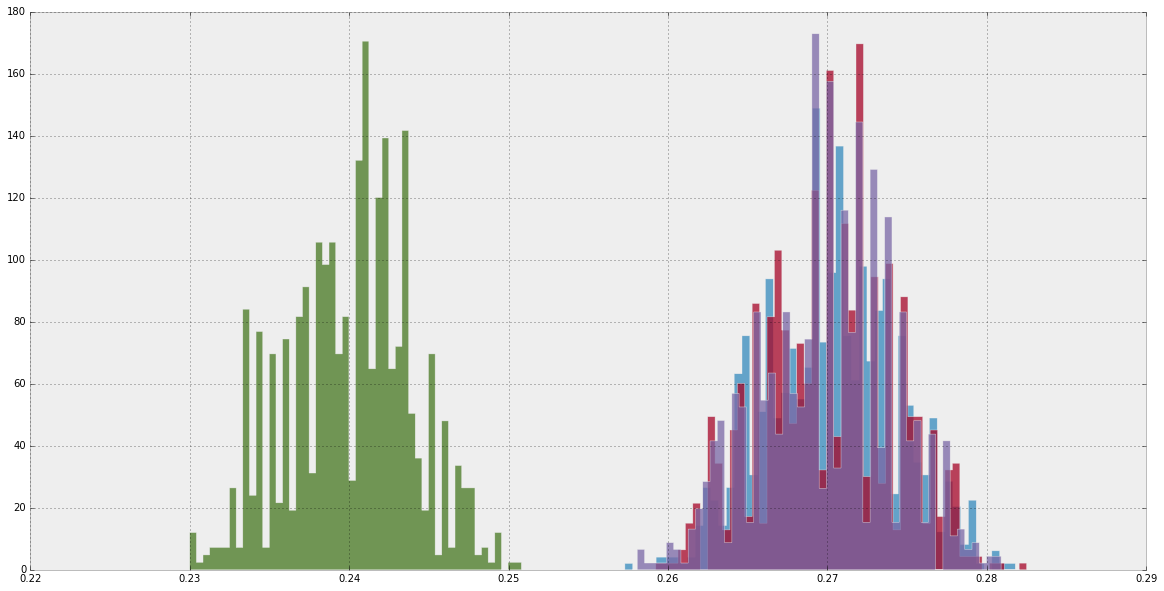

In [26]:
plt.style.use('bmh')
plt.figure(figsize=(20,40))
for bond in range(len(distance)):
    #print bonds[bond]
    plt.subplot(8, 3, bond+1)
    plt.title('Bond lenght between '+str(bonds[bond][0])+" and "+str(bonds[bond][1])+
              '\nAA: mean: '+"{0:.3f}".format((np.mean(distance[bond]))) +' std: '+"{0:.3f}".format(np.std(distance[bond]))+
              '\nCG: mean: '+"{0:.3f}".format((np.mean(distance_cg[bond]))) +' std: '+"{0:.3f}".format(np.std(distance_cg[bond])))
    plt.hist(distance[bond], 50, normed=1, alpha=0.75, histtype="stepfilled",label="AA")
    plt.hist(distance_cg[bond],50, normed=1, alpha=0.75, histtype="stepfilled", label="CG")
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
plt.figure(figsize=(20, 10))
for bond in range(len(distance)):
    #print bonds[bond]
    plt.hist(distance[bond], 50, normed=1, alpha=0.75, histtype="stepfilled",label=str(bonds[bond]))
plt.legend(loc='upper right')
plt.show()    
plt.figure(figsize=(20, 10))
for bond in range(len(distance)):
    #print bonds[bond]
    plt.hist(distance_cg[bond], 50, normed=1, alpha=0.75, histtype="stepfilled")
plt.show()    

In [18]:
print "[ bonds ]"
for bond in range(len(bonds)):
    print " ",bonds[bond][0],"   ",bonds[bond][1],"  1  ", np.mean(distance[bond]),"  ", int(0.6*np.std(distance[bond])**(-2.358))


[ bonds ]
  1     2   1   0.161453183015    1621629
  1     3   1   0.162709913486    2374499
  2     3   1   0.155891364873    1599591
  3     4   1   0.241504611852    471804




# Angles



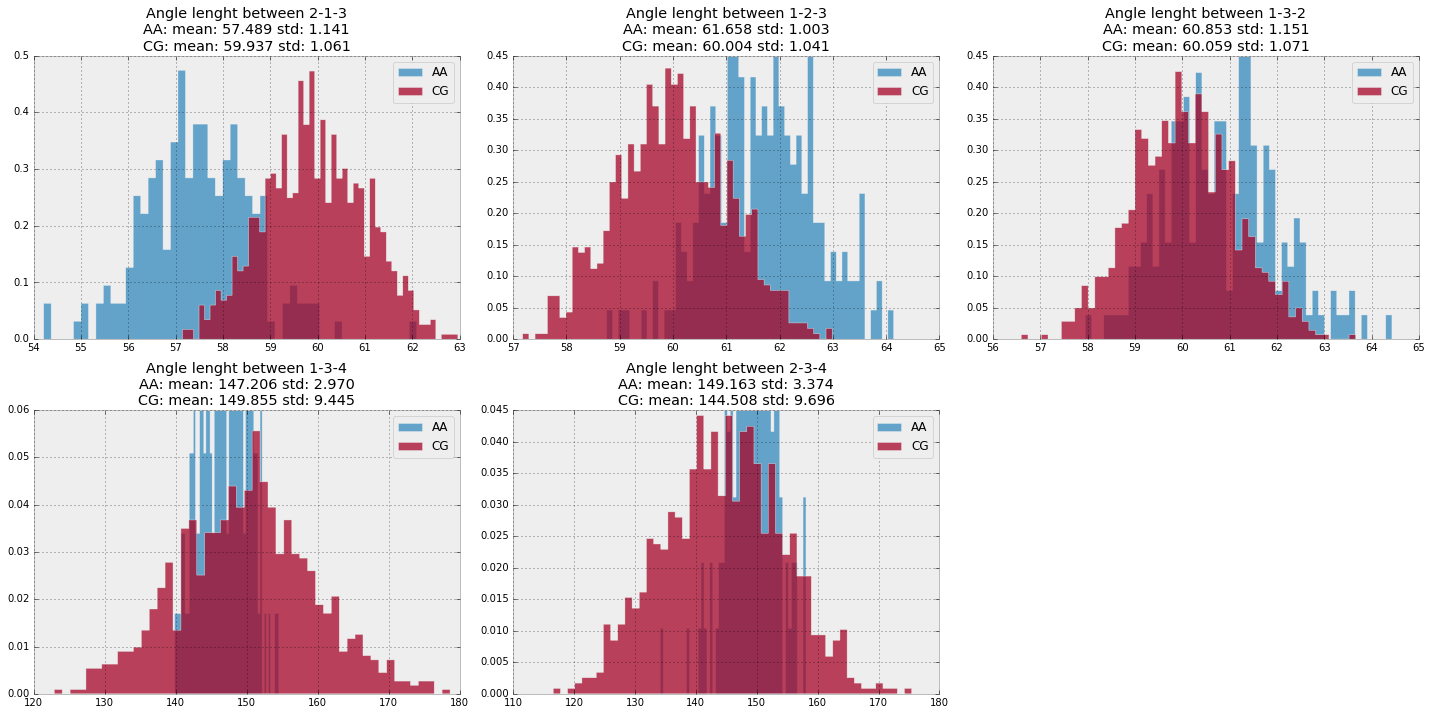

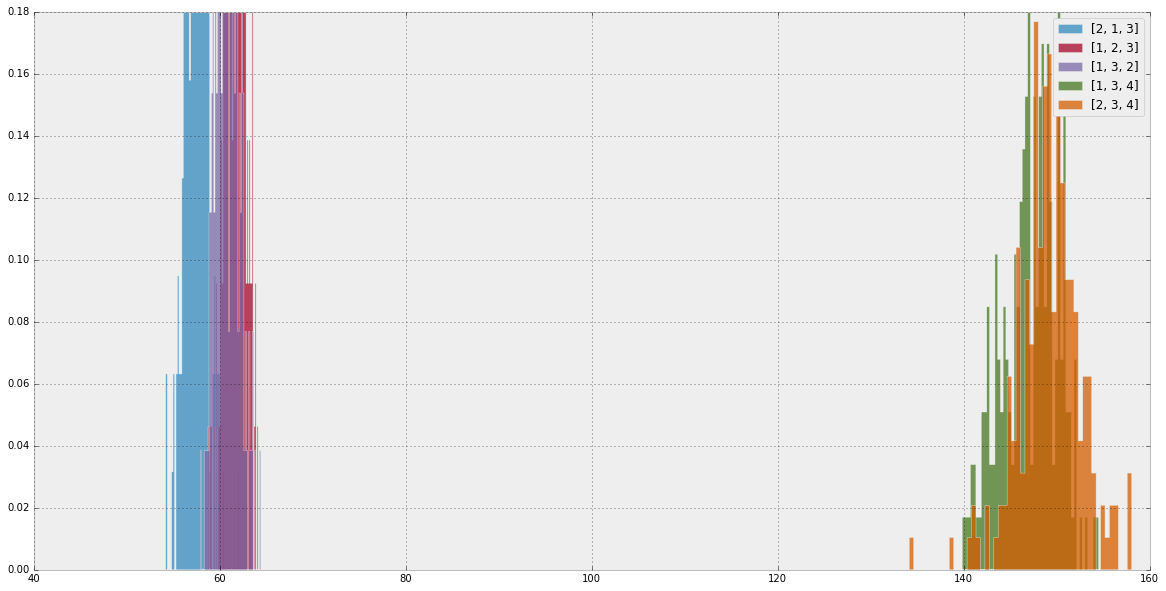

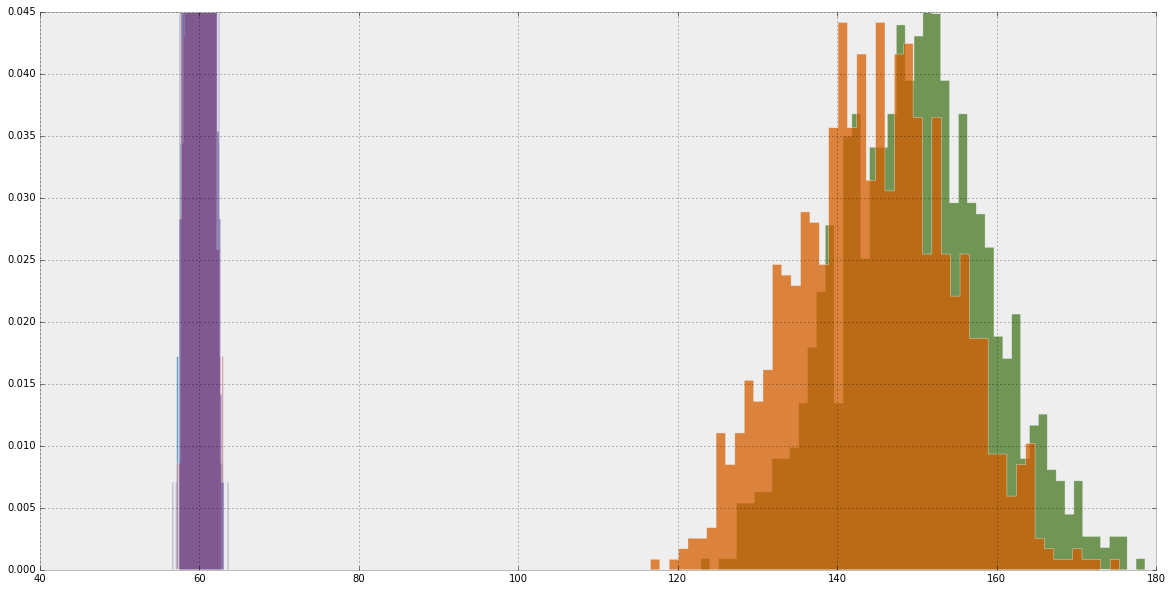

In [27]:
plt.style.use('bmh')
plt.figure(figsize=(20,(int(len(angles)/3)+1)*5))
for angle in range(len(degree)):
    #print bonds[bond]
    plt.subplot(int(len(angles)/3)+1, 3, angle+1)
    plt.title('Angle lenght between '+str(angles[angle][0])+"-"+str(angles[angle][1])+"-"+str(angles[angle][2])+
              '\nAA: mean: '+"{0:.3f}".format((np.mean(degree[angle]))) +' std: '+"{0:.3f}".format(np.std(degree[angle]))+
              '\nCG: mean: '+"{0:.3f}".format((np.mean(degree_cg[angle]))) +' std: '+"{0:.3f}".format(np.std(degree_cg[angle])))
    plt.hist(degree[angle], 50, normed=1, alpha=0.75, histtype="stepfilled",label="AA")
    plt.hist(degree_cg[angle],50, normed=1, alpha=0.75, histtype="stepfilled", label="CG")
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
for angle in range(len(degree)):
    #print bonds[bond]
    plt.hist(degree[angle], 50, normed=1, alpha=0.75, histtype="stepfilled",label=str(angles[angle]))
plt.legend(loc='upper right')
plt.show()    
plt.figure(figsize=(20, 10))
for angle in range(len(degree)):
    #print bonds[bond]
    plt.hist(degree_cg[angle], 50, normed=1, alpha=0.75, histtype="stepfilled")
plt.show()    


In [ ]:
for angle in range(len(angles)):
    print angles[angle][0],"  ", angles[angle][1],"  ", angles[angle][2],"  2   ", np.mean(degree[angle])
    




# Dihedrals

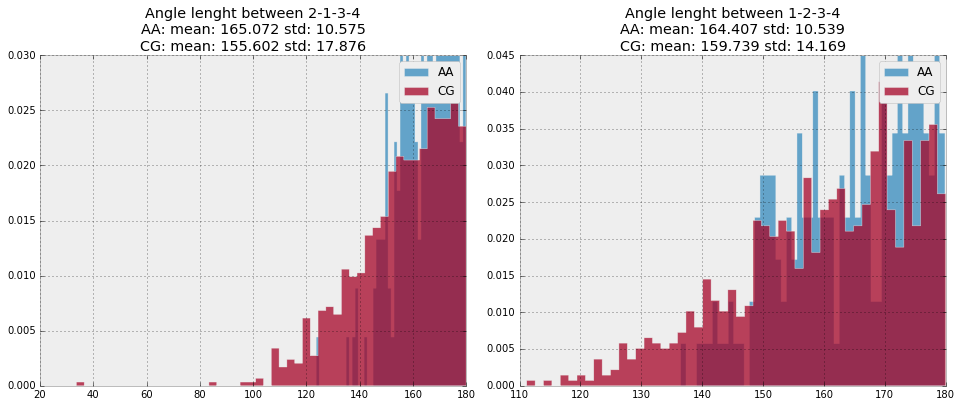

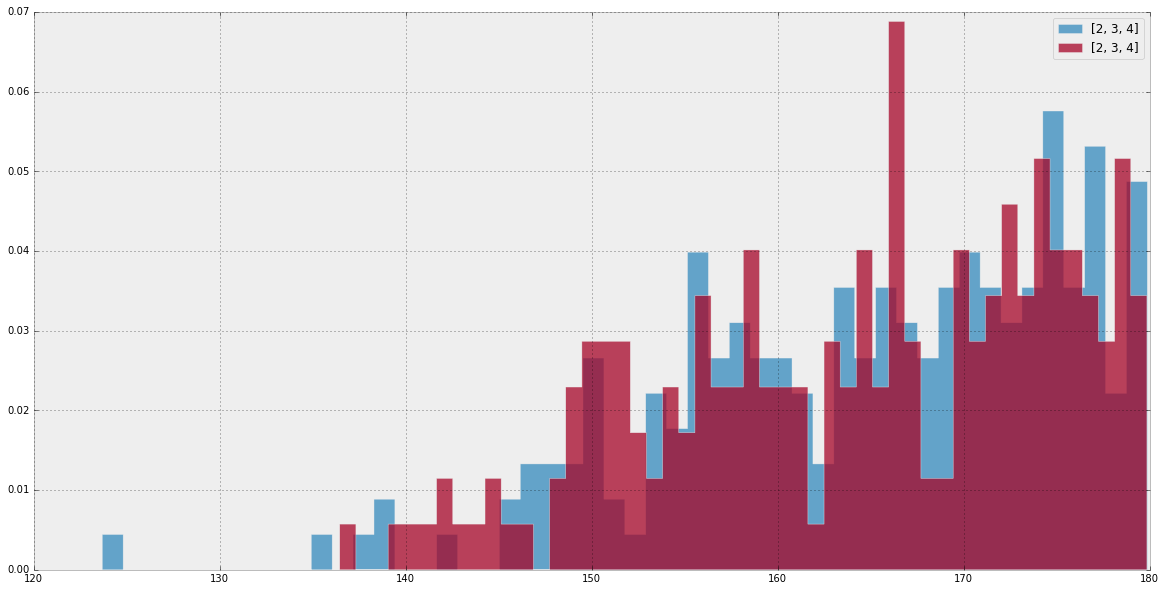

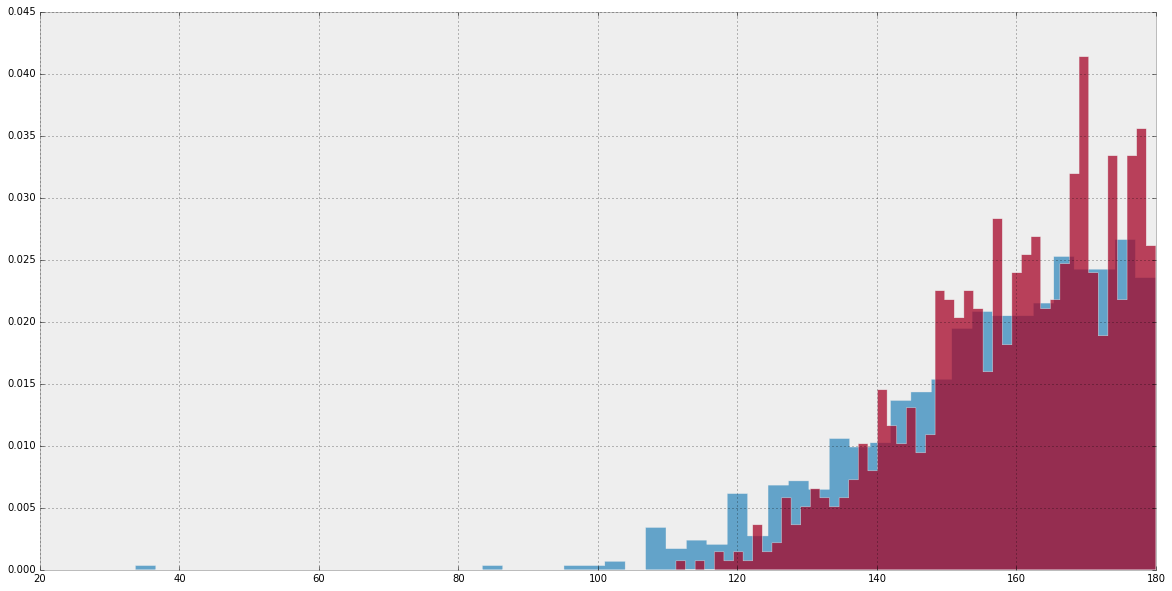

In [28]:
plt.style.use('bmh')
plt.figure(figsize=(20,40))
for dihedral in range(len(dih)):
    #print bonds[bond]
    plt.subplot(8, 3, dihedral+1)
    plt.title('Angle lenght between '+str(dihedrals[dihedral][0])+"-"+str(dihedrals[dihedral][1])+
                                  "-"+str(dihedrals[dihedral][2])+"-"+str(dihedrals[dihedral][3])+
              '\nAA: mean: '+"{0:.3f}".format((np.mean(dih[dihedral]))) +' std: '+"{0:.3f}".format(np.std(dih[dihedral]))+
              '\nCG: mean: '+"{0:.3f}".format((np.mean(dih_cg[dihedral]))) +' std: '+"{0:.3f}".format(np.std(dih_cg[dihedral])))
    plt.hist(dih[dihedral], 50, normed=1, alpha=0.75, histtype="stepfilled",label="AA")
    plt.hist(dih_cg[dihedral],50, normed=1, alpha=0.75, histtype="stepfilled", label="CG")
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
for dihedral in range(len(dih)):
    #print bonds[bond]
    plt.hist(dih[dihedral], 50, normed=1, alpha=0.75, histtype="stepfilled",label=str(angles[angle]))
plt.legend(loc='upper right')
plt.show()    
plt.figure(figsize=(20, 10))
for dihedral in range(len(dih)):
    #print bonds[bond]
    plt.hist(dih_cg[dihedral], 50, normed=1, alpha=0.75, histtype="stepfilled")
plt.show()    
